In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.losses import CategoricalCrossentropy
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy,F1Score,Precision,Recall
from tensorflow.keras.layers import Conv2D,Input,MaxPool2D,Dense,BatchNormalization,Flatten,Dropout,GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [2]:
path="/kaggle/input/grayscale-face-images/Grayscale Face images/train/happy"
sample_files=[os.path.join(path,i) for i in os.listdir(path)]

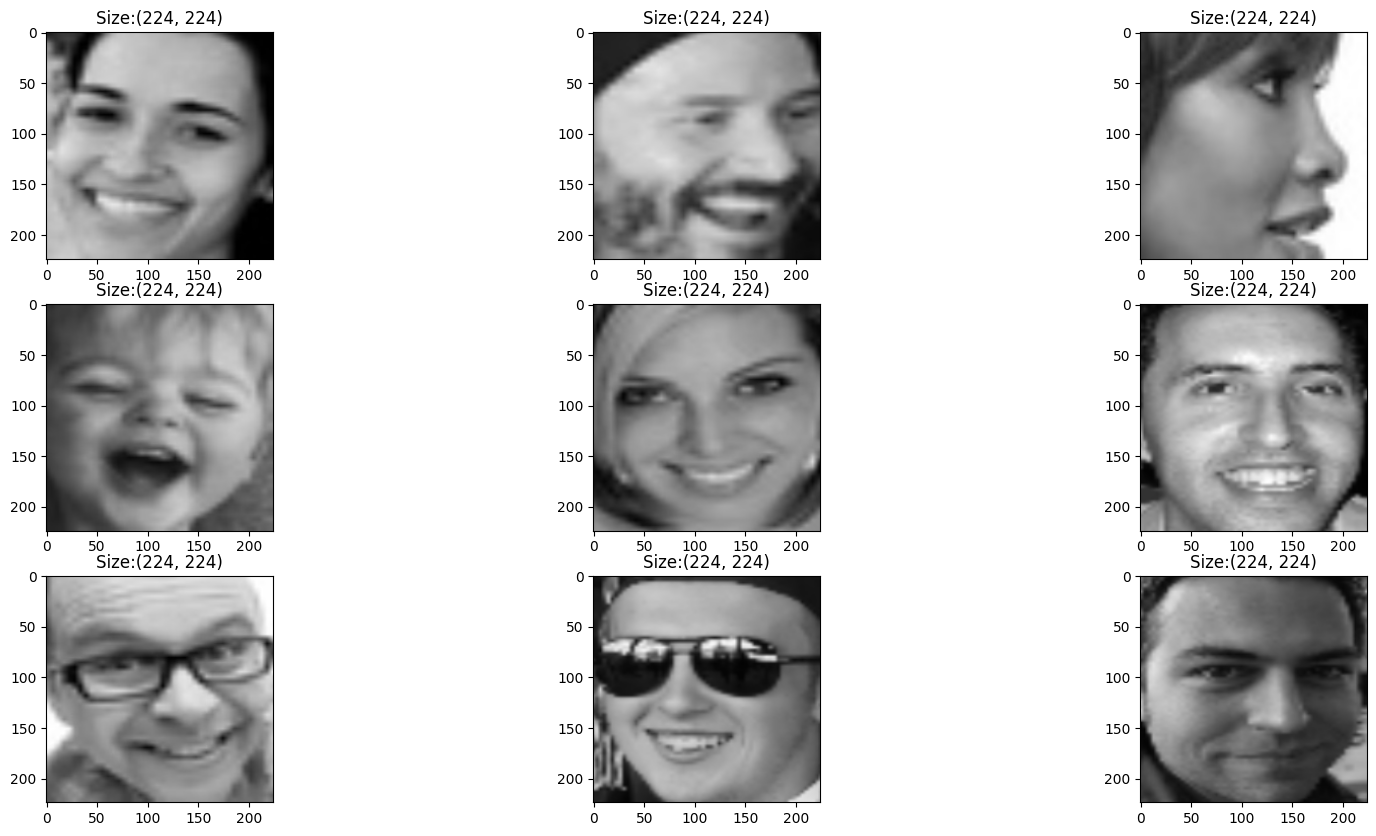

In [3]:
fig,axis=plt.subplots(3,3,figsize=(20,10))
axis=axis.flatten()
count=0
rand_indices=np.random.randint(0,len(sample_files),size=(9,1)).flatten()
for i in range(len(rand_indices)):
    image=load_img(sample_files[rand_indices[i]])
    axis[count].imshow(image)
    axis[count].set_title("Size:"+str(image.size))
    count+=1

> Image Size is (224,224) 

In [4]:
CONFIG={
    "BATCH_SIZE":8,
    "IMG_SIZE":(224,224),
    "STRIDE_1":1,
    "STRIDE_2":2,
    "REGUL":0.001,
    "DROP_OUT":0.2,
    "DENSE_L1":1024,
    "DENSE_L2":512,
    "DENSE_L3":256,
    "DENSE_L4":128,
    "KERNEL_SIZE_3":(3,3),
    "KERNEL_SIZE_2":(5,5),
    "KERNEL_SIZE_1":(7,7),
    "LR":0.001,
    "CLASS_NAMES":['anger','contempt','disgust','fear','happy','neutral','sad','surprise'],
    "POOL_SIZE":(2,2),
    "train_path":"/kaggle/input/grayscale-face-images/Grayscale Face images/train",
    "test_path":"/kaggle/input/grayscale-face-images/Grayscale Face images/test",
    "val_path":"/kaggle/input/grayscale-face-images/Grayscale Face images/validation",
    "FILTERS":64
    
}

In [5]:
img_gen=ImageDataGenerator(rescale=1/255.0)

In [6]:
train_gen=img_gen.flow_from_directory(directory=CONFIG["train_path"],target_size=CONFIG["IMG_SIZE"],batch_size=CONFIG['BATCH_SIZE'],shuffle=True,class_mode='categorical',color_mode='grayscale')

Found 90043 images belonging to 8 classes.


In [7]:
test_gen=img_gen.flow_from_directory(directory=CONFIG["test_path"],target_size=CONFIG["IMG_SIZE"],batch_size=CONFIG['BATCH_SIZE'],shuffle=True,class_mode='categorical',color_mode='grayscale')

Found 19302 images belonging to 8 classes.


In [8]:
val_gen=img_gen.flow_from_directory(directory=CONFIG["val_path"],target_size=CONFIG["IMG_SIZE"],batch_size=CONFIG['BATCH_SIZE'],shuffle=True,class_mode='categorical',color_mode='grayscale')

Found 19292 images belonging to 8 classes.


In [9]:
x,y=next(train_gen)

In [10]:
# Plotting Generator Images

In [11]:
images=x
labels=np.argmax(y,axis=-1)

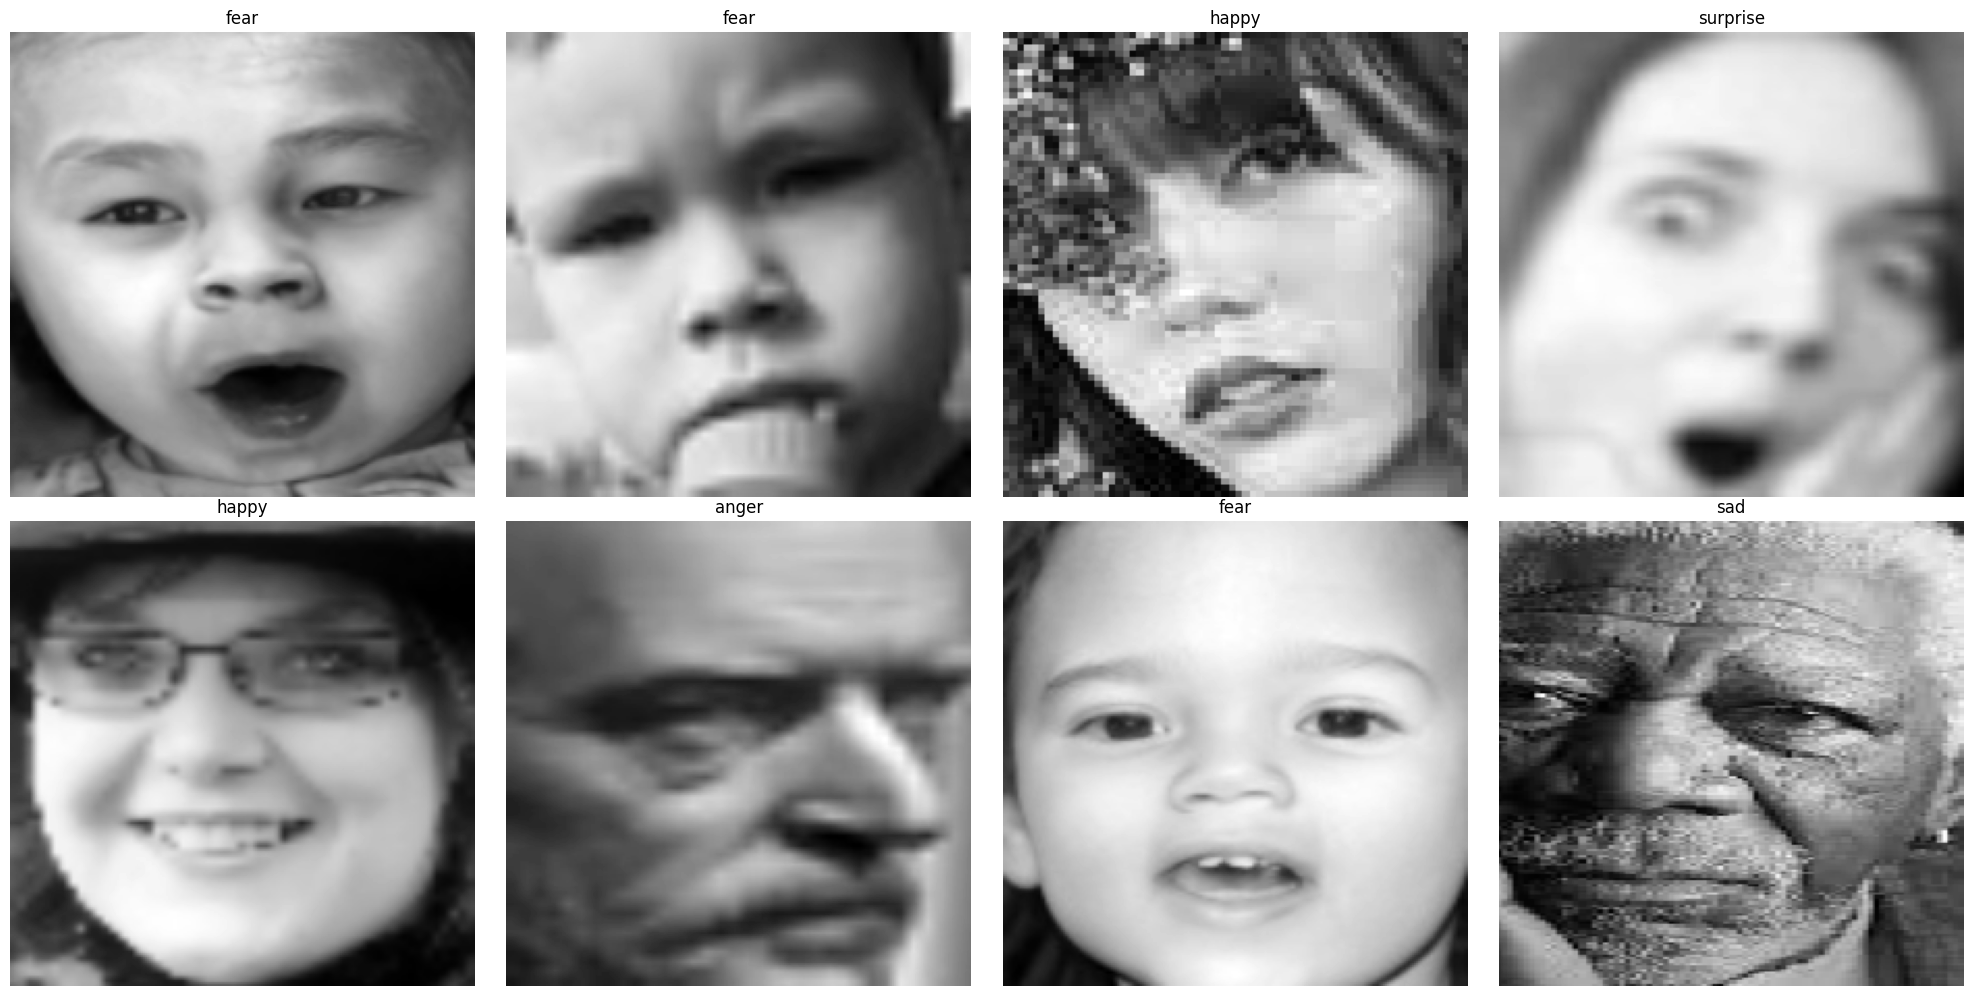

In [12]:
fig,axis=plt.subplots(2,4,figsize=(20,10))
axis=axis.flatten()
count=0
for i in range(len(labels)):

    axis[count].imshow(images[i],cmap='gray')
    title=CONFIG['CLASS_NAMES'][labels[i]]
    axis[count].set_title(title)
    axis[count].axis('off')
    count+=1
    
plt.tight_layout()


In [13]:
def get_model(input_shape=(224,224,1),no_of_labels=8):
    tf.keras.backend.clear_session()
    i=Input(shape=input_shape)
    #First
    x=Conv2D(filters=CONFIG["FILTERS"],kernel_size=CONFIG['KERNEL_SIZE_1'],activation='relu',strides=CONFIG['STRIDE_1'],padding='valid',kernel_regularizer=l2(CONFIG['REGUL']))(i)
    x=MaxPool2D(pool_size=CONFIG['POOL_SIZE'],strides=CONFIG['STRIDE_2'])(x)
    x=BatchNormalization()(x)
    #Second
    x=Conv2D(filters=CONFIG["FILTERS"]*2,kernel_size=CONFIG['KERNEL_SIZE_1'],activation='relu',strides=CONFIG['STRIDE_1'],padding='valid',kernel_regularizer=l2(CONFIG['REGUL']))(x)
    x=MaxPool2D(pool_size=CONFIG['POOL_SIZE'],strides=CONFIG['STRIDE_2'])(x)
    x=BatchNormalization()(x)
    x=Dropout(rate=CONFIG["DROP_OUT"])(x)
    #Third
    x=Conv2D(filters=CONFIG["FILTERS"]*4,kernel_size=CONFIG['KERNEL_SIZE_2'],activation='relu',strides=CONFIG['STRIDE_1'],padding='valid',kernel_regularizer=l2(CONFIG['REGUL']))(x)
    x=MaxPool2D(pool_size=CONFIG['POOL_SIZE'],strides=CONFIG['STRIDE_2'])(x)
    x=BatchNormalization()(x)
    
    x=GlobalAveragePooling2D()(x)
    
    x=Dense(units=CONFIG["DENSE_L1"],activation='relu')(x)
    x=Dense(units=CONFIG["DENSE_L2"],activation='relu')(x)
    x=Dropout(rate=CONFIG["DROP_OUT"])(x)
    x=Dense(units=CONFIG["DENSE_L3"],activation='relu')(x)
    x=Dense(units=CONFIG["DENSE_L4"],activation='relu')(x)
    x=Dropout(rate=CONFIG["DROP_OUT"])(x)
    
    x=Dense(no_of_labels,activation='softmax',name='last_layer')(x)
    
    return Model(i,x)
    

In [14]:
model=get_model()

In [15]:
import gc
import tensorflow as tf

# Clear session
tf.keras.backend.clear_session()

# Manually clear variables
gc.collect()


0

In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 218, 218, 64)   │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 103, 103, 128)  │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 51, 51, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 51, 51, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 47, 47, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 23, 23, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_layer (Dense)              │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,179,208 (8.31 MB)

 Trainable params: 2,178,312 (8.31 MB)

 Non-trainable params: 896 (3.50 KB)

In [17]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=Adam(learning_rate=CONFIG['LR']))

In [18]:
steps_per_epoch=len(train_gen)//CONFIG['BATCH_SIZE']
validation_steps=len(val_gen)//CONFIG["BATCH_SIZE"]

In [19]:
callbacks=[EarlyStopping(monitor='val_loss',patience=10,mode='min',verbose=1),
           ReduceLROnPlateau(monitor='val_loss',mode='min',patience=3,verbose=1),
           ModelCheckpoint(filepath='/kaggle/working/checked_model.keras',monitor='val_loss',mode='min',save_best_only=True,save_freq='epoch')]

In [20]:
model.fit(train_gen,batch_size=CONFIG['BATCH_SIZE'],epochs=150,callbacks=callbacks,validation_data=val_gen,steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Epoch 1/150


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726224621.062045      88 service.cc:145] XLA service 0x7d97c0002490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726224621.062111      88 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   3/1407 ━━━━━━━━━━━━━━━━━━━━ 1:29 64ms/step - accuracy: 0.0764 - loss: 2.3808  

I0000 00:00:1726224632.568064      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 113s 69ms/step - accuracy: 0.1360 - loss: 2.2029 - val_accuracy: 0.1416 - val_loss: 2.1085 - learning_rate: 0.0010
Epoch 2/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 90s 64ms/step - accuracy: 0.1333 - loss: 2.0905 - val_accuracy: 0.1292 - val_loss: 2.0829 - learning_rate: 0.0010
Epoch 3/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - accuracy: 0.1415 - loss: 2.0874 - val_accuracy: 0.1370 - val_loss: 2.0819 - learning_rate: 0.0010
Epoch 4/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 80s 57ms/step - accuracy: 0.1360 - loss: 2.0869 - val_accuracy: 0.1453 - val_loss: 2.0855 - learning_rate: 0.0010
Epoch 5/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 91s 65ms/step - accuracy: 0.1390 - loss: 2.0913 - val_accuracy: 0.1433 - val_loss: 2.0864 - learning_rate: 0.0010
Epoch 6/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1442 - loss: 2.0914
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 79s 56ms/step - accuracy: 0.

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1071 - val_loss: 2.0590 - learning_rate: 1.0000e-04
Epoch 10/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 68s 48ms/step - accuracy: 0.1637 - loss: 2.0586 - val_accuracy: 0.1462 - val_loss: 2.0822 - learning_rate: 1.0000e-04
Epoch 11/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 66s 47ms/step - accuracy: 0.1747 - loss: 2.0373 - val_accuracy: 0.2076 - val_loss: 2.0042 - learning_rate: 1.0000e-04
Epoch 12/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 64s 45ms/step - accuracy: 0.1848 - loss: 2.0176 - val_accuracy: 0.2226 - val_loss: 1.9777 - learning_rate: 1.0000e-04
Epoch 13/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 62s 44ms/step - accuracy: 0.2030 - loss: 2.0041 - val_accuracy: 0.1852 - val_loss: 2.0183 - learning_rate: 1.0000e-04
Epoch 14/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 42ms/step - accuracy: 0.2043 - loss: 1.9916 - val_accuracy: 0.2184 - val_loss: 1.9713 - learning_rate: 1.0000e-04
Epoch 15/150
1407/1407 ━━━━━━━━━━━━